## Dynamic Risk Budgeting

In [1]:
import numpy as np
import pandas as pd
import risk_kit as kit
import matplotlib.pyplot as plt
import seaborn as sns
import warnings

In [2]:
warnings.filterwarnings('ignore')
%matplotlib inline
%load_ext autoreload
%autoreload 2

In [6]:
n_scenarios = 5000
rates, zc_prices = kit.cir(10, n_scenarios=n_scenarios, b=0.03, r_0=0.03, sigma=0.02)
price_equity = kit.gbm(n_years=10, n_scenarios=n_scenarios, mu=0.07, sigma=0.15)

In [9]:
# Generate returns
returns_equity =  price_equity.pct_change().dropna()
# Compute the returns of zero-coupon bond. 
returns_zerocoupon = zc_prices.pct_change().dropna()
returns_7030bond = kit.backtest_mix(returns_equity, returns_zerocoupon, allocator=kit.fixed_mix_allocator, w1=0.7)
# Using the zero-coupons as a proxy for a duration matched portfolio.
# It was proved that we can use regular bonds to construct a duration matched portfolio 
# that matches our liabilities and gives us many of the same advantages that a zero-coupon bond would.
pd.concat([
            kit.terminal_stats(returns_zerocoupon, name="ZC", floor=0.75),
            kit.terminal_stats(returns_equity, name="Eq", floor=0.75),
            kit.terminal_stats(returns_7030bond, name="70/30", floor=0.75),
          ], axis=1).round(2)

,ZC,Eq,70/30
mean,1.34,1.99,1.77
std,0.00,1.01,0.60
p_breach,NaN,0.03,0.01
e_short,NaN,0.12,0.06
p_reach,NaN,NaN,NaN
e_surplus,NaN,NaN,NaN


This shows the basic fundamental problem thatno matter what we do with these simplistic mixes, we are not able to solve this breach problem.

The reason these breaches are happening is because the allocator is blind to the floor that I have targetted. So it makes sense that these things will not be able to meet the floor requirement.

In [10]:
# New allocator which takes consideration of the floor
def floor_allocator(psp_r, ghp_r, floor, zc_prices, m=3):
    """
    Allocate between PSP and GHP withthe goal to provide exposure to the upside
    of the PSP without violating the floor requirement.
    Uses a CPPI-style dynamic risk budgeting algorithm by investing a multiple of the cushion 
    in the PSP.
    Returns a dataframe with the same shape as the php/ghp representing the weights in the PSP.
    """
    if zc_prices.shape != psp_r.shape:
        raise ValueError("PSP and ZC prices must have the same shape")
    
    n_steps, n_scenarios = psp_r.shape
    # Start with a $1 in every single scenario
    account_value = np.repeat(1, n_scenarios)
    floor_value = np.repeat(1, n_scenarios)
    w_history = pd.DataFrame(index=psp_r.index, columns=psp_r.columns)
    for step in range(n_steps):
        floor_value = floor*zc_prices.iloc[step] # PV of Floor assuming today's rates and flat YC
        cushion = (account_value - floor_value)/account_value
        psp_w = (m*cushion).clip(0,1) #same as applying min and max
        ghp_w = 1 - psp_w
        psp_alloc = account_value*psp_w
        ghp_alloc = account_value*ghp_w
        # Recompute the account value at the end of this step.
        account_value = psp_alloc * (1+psp_r.iloc[step]) + ghp_alloc * (1+ghp_r.iloc[step])
        w_history.iloc[step] = psp_w
    return w_history

    The reason the allocator needs the zero coupon bond prices is because it can then discount the value of that floor to the present value. Because, if you know the price of zero coupon bond today, you know exactly what the present value of the floor is. Because it's nothing more than the discounted value of the floor and the discount to apply is exactly what the discount value is today for a zero coupon bond, that is nothing more than the price of the zero-coupon bond.

The job of this allocator is to make sure that as account value gets closer and closer to the present value of the floor, its going to get more and more into the safe asset, into the GHP, into the zero-coupon bond in this particular case or the duration matched portfolio.

In [11]:
returns_floor75 = kit.backtest_mix(returns_equity, returns_zerocoupon, allocator=floor_allocator, 
                                floor=0.75, zc_prices=zc_prices[1:])

pd.concat([
            kit.terminal_stats(returns_zerocoupon, name="ZC", floor=0.75),
            kit.terminal_stats(returns_equity, name="Eq", floor=0.75),
            kit.terminal_stats(returns_7030bond, name="70/30", floor=0.75),
            kit.terminal_stats(returns_floor75, name="floor75", floor=0.75)
          ], axis=1).round(2)

,ZC,Eq,70/30,floor75
mean,1.34,1.99,1.77,1.97
std,0.00,1.01,0.60,1.01
p_breach,NaN,0.03,0.01,NaN
e_short,NaN,0.12,0.06,NaN
p_reach,NaN,NaN,NaN,NaN
e_surplus,NaN,NaN,NaN,NaN


We are doing monthly rebalancing here.

The returns were actually better than the 70-30 fixed mix (1.97 vs 1.77). But it is not as good as 100% (1.99). You are giving up about 2cents of terminal value but you are saving about 12cents of possible shortfall.

These dynamic strategies trade off some upside in exchange for cutting off the downside (option-like behaviour).

This ouput has been good. There is no breaches of the floor mainly because we have been rebalancing every month. 

Now, try a different strategy.

In [12]:
returns_floor75m1 = kit.backtest_mix(returns_equity, returns_zerocoupon, allocator=floor_allocator, 
                                floor=0.75, zc_prices=zc_prices[1:], m=1)

# m=1 means I will put only the cushion in PSP. If thepresent value of my floor is 80 
# and I have 100, I have 20% cushion. I'll put 20% in equities and 80% in safe assets, in bonds.
# That is a very inefficient way of doing it but it does make sure that you won't have any violations.

# slightly more risky version.
returns_floor75m5 = kit.backtest_mix(returns_equity, returns_zerocoupon, allocator=floor_allocator, 
                                floor=0.75, zc_prices=zc_prices[1:], m=5)


pd.concat([
            kit.terminal_stats(returns_zerocoupon, name="ZC", floor=0.75),
            kit.terminal_stats(returns_equity, name="Eq", floor=0.75),
            kit.terminal_stats(returns_7030bond, name="70/30", floor=0.75),
            kit.terminal_stats(returns_floor75, name="floor75", floor=0.75),
            kit.terminal_stats(returns_floor75m1, name="floor75m1", floor=0.75),
            kit.terminal_stats(returns_floor75m5, name="floor75m5", floor=0.75)
          ], axis=1).round(2)


,ZC,Eq,70/30,floor75,floor75m1,floor75m5
mean,1.34,1.99,1.77,1.97,1.63,1.98
std,0.00,1.01,0.60,1.01,0.44,1.01
p_breach,NaN,0.03,0.01,NaN,NaN,0.00
e_short,NaN,0.12,0.06,NaN,NaN,0.00
p_reach,NaN,NaN,NaN,NaN,NaN,NaN
e_surplus,NaN,NaN,NaN,NaN,NaN,NaN


In [13]:
# To check the breach (to see decimal places)
pd.concat([
            kit.terminal_stats(returns_zerocoupon, name="ZC", floor=0.75),
            kit.terminal_stats(returns_equity, name="Eq", floor=0.75),
            kit.terminal_stats(returns_7030bond, name="70/30", floor=0.75),
            kit.terminal_stats(returns_floor75, name="floor75", floor=0.75),
            kit.terminal_stats(returns_floor75m1, name="floor75m1", floor=0.75),
            kit.terminal_stats(returns_floor75m5, name="floor75m5", floor=0.75)
          ], axis=1).round(4)

,ZC,Eq,70/30,floor75,floor75m1,floor75m5
mean,1.3433,1.9926,1.7711,1.9682,1.6320,1.9790
std,0.0000,1.0054,0.6026,1.0124,0.4436,1.0137
p_breach,NaN,0.0300,0.0068,NaN,NaN,0.0002
e_short,NaN,0.1215,0.0633,NaN,NaN,0.0000
p_reach,NaN,NaN,NaN,NaN,NaN,NaN
e_surplus,NaN,NaN,NaN,NaN,NaN,NaN


With m=1, there is no breach, but I have to give up so much of upside.

With m=5, I get the terminal values close tp equities, but there are a very small number of breaches.

### Risk Budgeting with Drawdown Constraints - Drawdown Allocator

The risk budget is not determined in terms of how much I need at the very end but I need to make sure that I do not lose more than a certain amount of money. 

The drawdown should never be less than a certain percentage. 

The interesting thing is, you don't have a distant liability. Your liability is well known at any given point in time. Even in a minute from now you do not want to be less than a certain % from where you were in the past. That is a very very short term liability. SO that is a case where you can use cash because cash is very very very short term instrument. The duration of cash is basically zero. 

So it is an interesting case of how you can build a portfolio that has a drawdown constraint than a fixed floor constraint.


In [16]:
def drawdown_allocator(psp_r, ghp_r, maxdd, m=3):
    """
    Allocate between PSP and GHP withthe goal to provide exposure to the upside
    of the PSP without violating the floor requirement.
    Uses a CPPI-style dynamic risk budgeting algorithm by investing a multiple of the cushion 
    in the PSP.
    Returns a dataframe with the same shape as the php/ghp representing the weights in the PSP.
    """
    n_steps, n_scenarios = psp_r.shape
    # Start with a $1 in every single scenario
    account_value = np.repeat(1, n_scenarios)
    floor_value = np.repeat(1, n_scenarios)
    peak_value = np.repeat(1, n_scenarios)
    w_history = pd.DataFrame(index=psp_r.index, columns=psp_r.columns)
    for step in range(n_steps):
        floor_value = (1-maxdd) * peak_value # Floor is based on previous peak
        cushion = (account_value - floor_value)/account_value
        psp_w = (m*cushion).clip(0,1) #same as applying min and max
        ghp_w = 1 - psp_w
        psp_alloc = account_value*psp_w
        ghp_alloc = account_value*ghp_w
        # Recompute the new account value and prev peak at the end of this step.
        account_value = psp_alloc * (1+psp_r.iloc[step]) + ghp_alloc * (1+ghp_r.iloc[step])
        peak_value = np.maximum(peak_value, account_value)
        w_history.iloc[step] = psp_w
    return w_history

The tricky part here is that you cannot use bonds anymore, not even zer-coupon bonds, because the bonds will drop in price at some point in time, where as you need something with a very, very short duration. And the zero-coupon bond has a duration out to whenever the coupon pays or whenever the bond matures.

In [18]:
# Assume cash rate is 2%. Simulate for every month.
cashrate = 0.02
monthly_cashreturn = (1+cashrate)**(1/12) - 1
# Generate return series - I need the returns of my safe asset
returns_cash = pd.DataFrame(data=monthly_cashreturn, index=returns_equity.index,
                            columns=returns_equity.columns)
# mixer doesn't care what the two portfolios are. Here cash is considered as safe asset.
returns_maxDrawdown25 = kit.backtest_mix(returns_equity, returns_cash, allocator=drawdown_allocator,
                                      maxdd=0.25)
# terminal values
terminal_maxDrawdown25 = kit.terminal_values(returns_maxDrawdown25)

In [19]:
# To check the breach (to see decimal places)
pd.concat([
            kit.terminal_stats(returns_zerocoupon, name="ZC", floor=0.75),
            kit.terminal_stats(returns_equity, name="Eq", floor=0.75),
            kit.terminal_stats(returns_7030bond, name="70/30", floor=0.75),
            kit.terminal_stats(returns_floor75, name="floor75", floor=0.75),
            kit.terminal_stats(returns_floor75m1, name="floor75m1", floor=0.75),
            kit.terminal_stats(returns_floor75m5, name="floor75m5", floor=0.75),
            kit.terminal_stats(returns_maxDrawdown25, name="Maxdd25", floor=0.75)
          ], axis=1).round(4)

,ZC,Eq,70/30,floor75,floor75m1,floor75m5,Maxdd25
mean,1.3433,1.9926,1.7711,1.9682,1.6320,1.9790,1.6410
std,0.0000,1.0054,0.6026,1.0124,0.4436,1.0137,0.5498
p_breach,NaN,0.0300,0.0068,NaN,NaN,0.0002,NaN
e_short,NaN,0.1215,0.0633,NaN,NaN,0.0000,NaN
p_reach,NaN,NaN,NaN,NaN,NaN,NaN,NaN
e_surplus,NaN,NaN,NaN,NaN,NaN,NaN,NaN


The point of using drawdown was not to avoid breaches, but to use drawdowns as a constraint.

In [20]:
kit.summary_stats(returns_maxDrawdown25)["Max Drawdown"].head()

0   -0.136627
1   -0.183201
2   -0.212337
3   -0.122761
4   -0.166547
Name: Max Drawdown, dtype: float64

In [21]:
# What was the worst drawdown
kit.summary_stats(returns_maxDrawdown25)["Max Drawdown"].min()

-0.2328299319753203

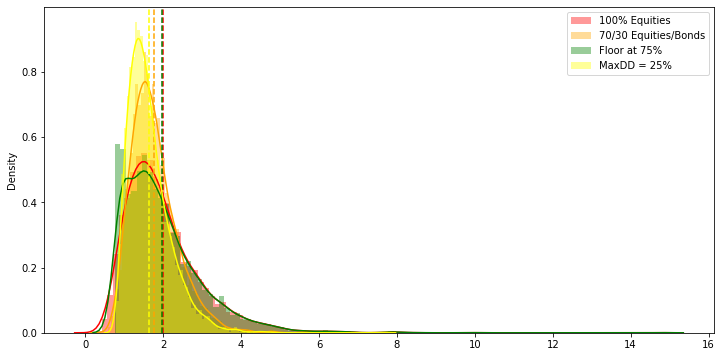

In [24]:
# Plot
terminal_equities = kit.terminal_values(returns_equity)
terminal_7030bond = kit.terminal_values(returns_7030bond)
terminal_floor75 = kit.terminal_values(returns_floor75)
terminal_maxDrawdown25 = kit.terminal_values(returns_maxDrawdown25)
plt.figure(figsize=(12,6))
sns.distplot(terminal_equities, color="red", label="100% Equities", bins=100)
plt.axvline(terminal_equities.mean(), ls="--", color="red")
sns.distplot(terminal_7030bond, color="orange", label="70/30 Equities/Bonds", bins=100)
plt.axvline(terminal_7030bond.mean(), ls="--", color="orange")
sns.distplot(terminal_floor75, color="green", label="Floor at 75%", bins=100)
plt.axvline(terminal_floor75.mean(), ls="--", color="green")
sns.distplot(terminal_maxDrawdown25, color="yellow", label="MaxDD = 25%", bins=100)
plt.axvline(terminal_maxDrawdown25.mean(), ls="--", color="yellow")
plt.legend()

Looking at the mean line, the floor strategy has a very very low loss of opportunity cost in comparison with the 100% equities.

A large part of how these strategies operate is to shift or shape, move the shape of the distribution towards something that is more acceptable to you. We are giving up some of the upside in exchange for eliminating some large part of the downside that you do not find acceptable.

### Drawdown Constraint with historic data

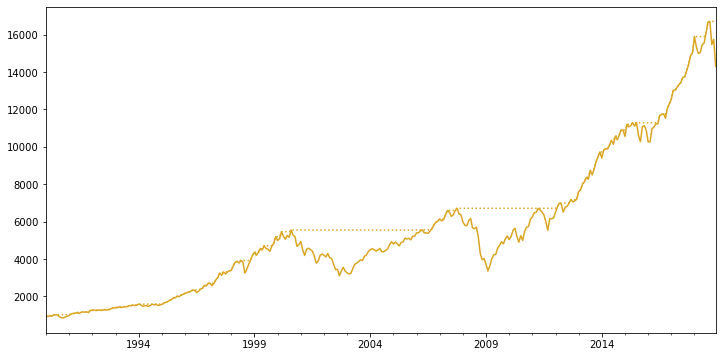

In [27]:
# Total market index
returns_tmi = kit.get_total_market_index_returns()["1990":]
drawdown_tmi = kit.drawdown(returns_tmi)
ax = drawdown_tmi["Wealth"].plot(figsize=(12,6), ls="-", color="goldenrod")
drawdown_tmi["Previous Peaks"].plot(ax=ax, ls=":", color="goldenrod")

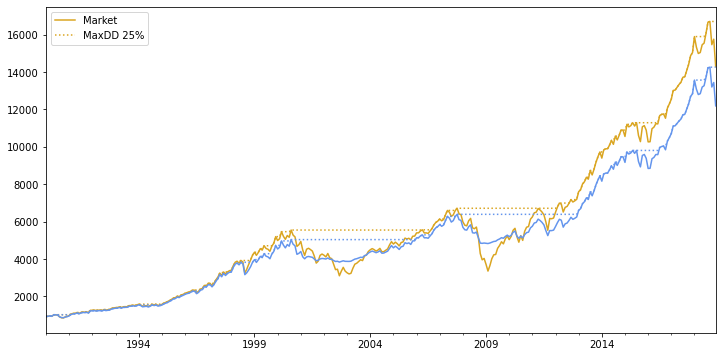

In [29]:
cashrate = 0.03
monthly_cashreturn = (1+cashrate)**(1/12) - 1
returns_cash = pd.DataFrame(data=monthly_cashreturn, index=returns_tmi.index,
                            columns=[0]) # 1 column dataframe
# backtesting with historic data
returns_maxDrawdown25 = kit.backtest_mix(pd.DataFrame(returns_tmi), returns_cash,
                                         allocator=drawdown_allocator, maxdd=0.25, m=5)
drawdown_25 = kit.drawdown(returns_maxDrawdown25[0]) # the only column


ax = drawdown_tmi["Wealth"].plot(figsize=(12,6), ls="-", color="goldenrod", label="Market", legend=True)
drawdown_tmi["Previous Peaks"].plot(ax=ax, ls=":", color="goldenrod")
drawdown_25["Wealth"].plot(figsize=(12,6), ax=ax, label="MaxDD 25%", color="cornflowerblue", legend=True)
drawdown_25["Previous Peaks"].plot(ax=ax, ls=":", color="cornflowerblue")

The blue shows the drawdowns had I been using the drawdown strategy.

In [31]:
# Check if the strategy worked
kit.summary_stats(pd.concat([returns_tmi.rename("Market"), 
                             returns_maxDrawdown25[0].rename("MaxDD")], axis=1))

,Annualied Return,Annualized Vol,Skewness,Kurtosis,Cornish-Fisher VaR (5%),Historic CVaR (5%),Sharpe Ratio,Max Drawdown
Market,0.096058,0.145419,-0.668827,4.247282,0.066949,0.094633,0.441951,-0.499943
MaxDD,0.090062,0.112755,-0.630463,5.015334,0.049978,0.071074,0.518327,-0.244212


The unconstrainted market gave 9.6% while drawdown constraint ave 9%. But looking at max drawdown, The market had almost 50% drawdown while the MaxDD had 24% as we had set the constraint to 25%.